# Project Final Report of Group 17

#### Github Link: https://github.com/Mantoj130/Data-Science-Project

In [1]:
#Run these beforehand
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Loading and cleaning dataset
players <- read_csv("players.csv")
#fix column names
colnames(players) <- c("experience","subscribe", "hashed_email", "played_hours", "name", "gender", "age")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Introduction

Background: A research group in Computer Science at UBC, led by Frank Wood, is collecting data about how people play video games. They have set up a MineCraft server where players' in-game actions are recordered as they navigate through the world.These data allow researchers to study player behavior in a naturalistic online environment, with the goal of understanding how players engage with the game and what factors drive deeper participation. 

Using the collected dataset, we aim to address a set of broad research questions. One practical challenge the team faced is the need to target recruitment effectively and ensure enough resources to handle the number of players they attract. Among 3 broad questions, we focus on the following:

Broad Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Research Question: Can age and experience predict whether or not a player is subscribed to a game-related newsletter in the `players.csv` dataset?

In [3]:
stat_played_hour <- players |> 
summarise(min_played_hours=min(played_hours), max_played_hours=max(played_hours), mean_played_hours=mean(played_hours))

stat_age <- players |> 
summarise(min_age=min(age,na.rm=TRUE), max_age=max(age,na.rm=TRUE), mean_age=mean(age,na.rm=TRUE))

#stat_age
#stat_played_hour

For `player.csv` , there are 196 observations and 7 columns.
1. `experience`, character, describes player's level as: `Pro`, `Veteran`, `Amateur`, `Regular`, and `Beginner`.
2. `subscribe`, logical, describes whether the player subscribed to the game info as: `TRUE` or `FALSE`.
3. `hashedEmail`, character, describes the hashed email address of the player.
4. `played_hours`, double, describes the player's playtime on the server, ranging from 0 to 223.1, with a mean of 5.85.
5. `name`, charater, describes the name of the player.
6. `gender`, charater, describes the player's gender as: `male`, `female`, `Non-binary`, `Prefer not to say`, `Agender`, `Two-Spirited` and `Other`.
7. `Age`, double, describes the player's age, ranging from 9 to 58, with a mean of 21.14.

## Methods
To answer this question we decided to use K-nearest neighbours classification to predict whether or not a player was subscribed using player age and experience. This method is appropriate because we can turn player experience into quantitative variables using the natural ascending order, and it is unlikely from our initial exploration that there will be a linear association between the explanatory and response variables. There are also very little assumptions required, only that distance between points is correlated to their similarity, which makes this method easy to apply here. It is possible that as we increase training data the algorithm may slow down, and may not be applicable outside the range of our explanatory variables. But since the amount of observations is not too high, and our explanatory variables have natural boundaries (lifespan and preset categories) that prevent us from having to predict outside of our range, these weaknesses of K-nearest neighbours classification should not limit the validity of our results. However, one weakness that may affect the results is the importance of having equal number of observations for each category of the variable that is going to be predicted. This is important because having an inequal amount would naturally cause the majority category to outvote the minority category near the decision boundaries.

After cleaning the data of null values, fixing the colunm names, and turning the subscribe and experience column into variables that the algorithm can work with, we set the seed for reproducibility purposes. We then split the data into testing and training subsets. Training took up 80% of the data, and the rest was used as testing to later evaluate the effectiveness our algorithm. Exploratory graphs of the experience, age, and subscription columns were created, showing no clear linear relation between any of the variables. RMSPE was then used to optimize the number of neighbours (K) with 10 fold cross validations and 5 repeats on the training subset. The algorithm was then evaluated using the testing subset, to produce an accuracy estimate for the model. A confusion matrix was also used to get a more comprehensive view of performance.

We repeated the above steps to create three models, one which used both age and experience to predict subscriber rate, and the others used just age or experience. The number of nearest neighbors was selected for when the accuracy estimate for each k-value roughly stopped improving. This lead to the age and experience model using 11 neighbors, while the other two used 17 neighbors. 

## Results

In [4]:
#filter out NA values
players <- players |> 
    filter(!is.na(age)) |>
    filter(!is.na(experience))
#add a numeric experience column
players$experience_numeric <- recode(players$experience, 
                          "Pro" = 5,
                          "Veteran" = 4, 
                          "Regular" = 3, 
                          "Amateur" = 2, 
                          "Beginner" = 1)
#add a factorized subscribed column
players$subscribe_factor <- factor(players$subscribe)
#mean(players$age)

[1] Figure 1: Exploratory Data Analysis


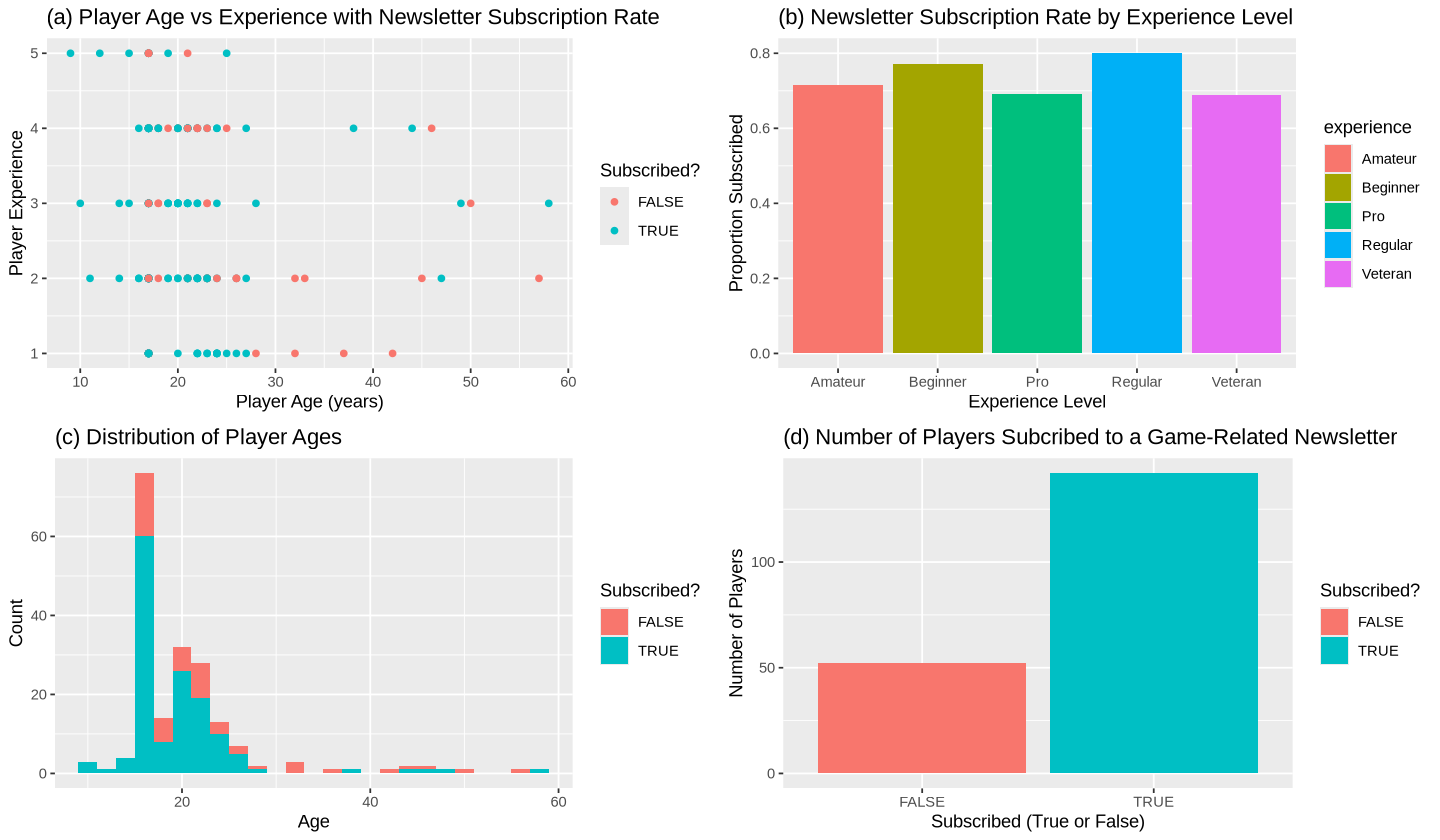

In [5]:
#exploration plots
options(repr.plot.width=12, repr.plot.height=7)
plot1 <- players |>
    ggplot(aes(x = age, y =  experience_numeric, colour = subscribe)) + 
        geom_point() +
        labs(x="Player Age (years)", y="Player Experience", colour="Subscribed?") +
        ggtitle("(a) Player Age vs Experience with Newsletter Subscription Rate")
plot2 <- players |>
    group_by(experience) |>
    summarize(prop_subscribe = mean(subscribe)) |>
    ggplot(aes(x= experience, y=prop_subscribe, fill = experience)) +
    geom_col() +
    labs(title = "(b) Newsletter Subscription Rate by Experience Level",
         x = "Experience Level",
         y = "Proportion Subscribed")
plot3 <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(binwidth = 2) +
    labs(title = "(c) Distribution of Player Ages",
            x = "Age", y = "Count", fill="Subscribed?")
plot4 <- players |>
    ggplot(aes(x = subscribe_factor, fill = subscribe_factor)) +
    geom_bar() +
    labs(x = "Subscribed (True or False)",
         y = "Number of Players",
         title = "(d) Number of Players Subcribed to a Game-Related Newsletter",
        fill="Subscribed?")

print("Figure 1: Exploratory Data Analysis", quote = FALSE)

grid.arrange(plot1, plot2, plot3, plot4, ncol = 2, widths = c(1,1))

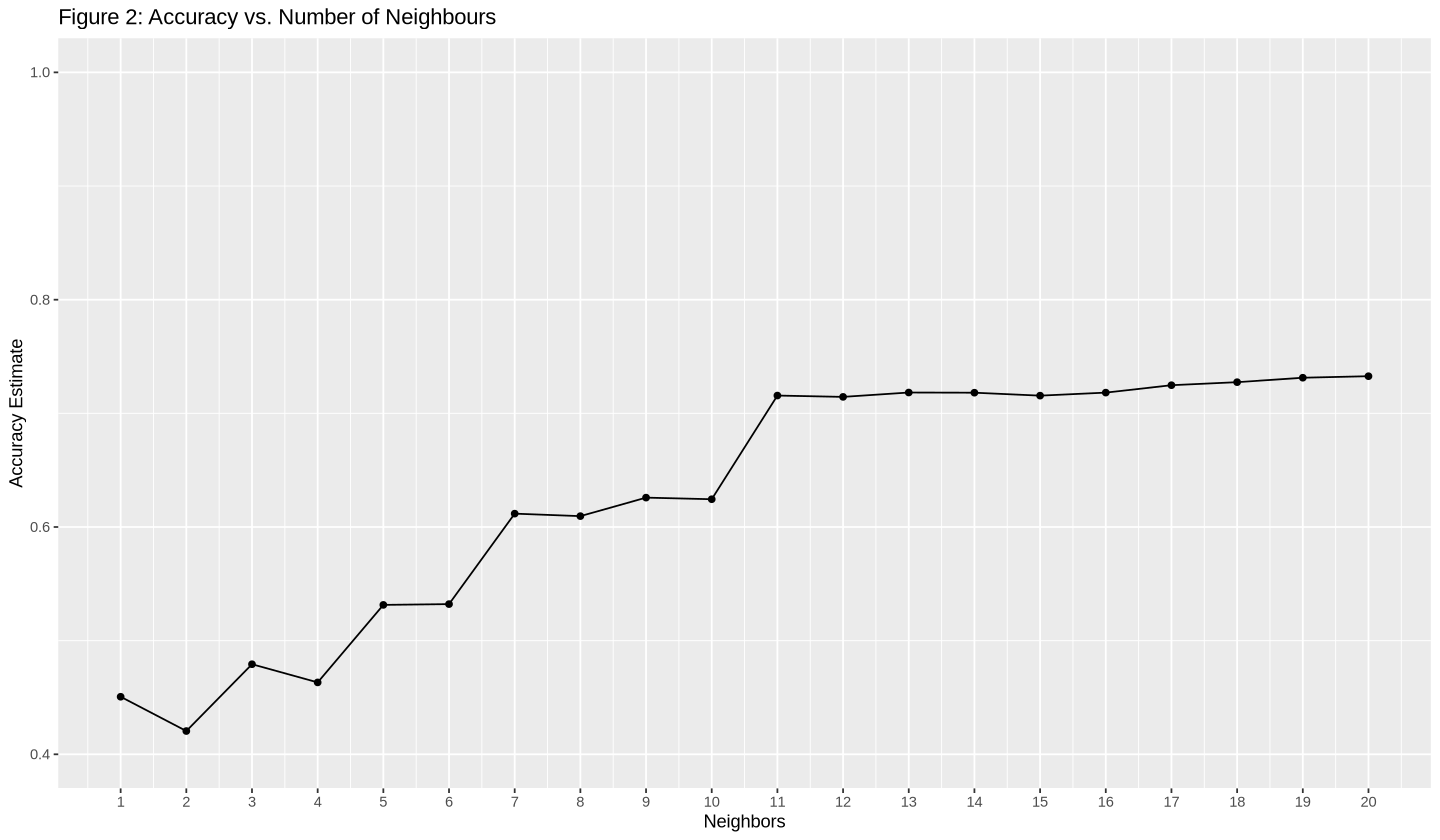

In [6]:
#Splitting dataset between training and testing
set.seed(9999) 
player_split <- initial_split(players, prop = 0.80, strata = subscribe_factor)  
player_train <- training(player_split)   
player_test <- testing(player_split)

#Setup classification
player_recipe <- recipe(subscribe_factor ~ age + experience_numeric, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("classification") 
player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)

#Find most accurate nearest neighbours
player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe_factor, repeats = 5)
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
player_results <- player_workflow |> 
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics()
accuracies <- player_results |> 
       filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", 
            y = "Accuracy Estimate", 
            title = "Figure 2: Accuracy vs. Number of Neighbours") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [7]:
#Select most accurate neighber and compare with testing dataset
set.seed(9999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")
player_best_spec <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(knn_spec)
player_fit <- fit(player_best_spec, data = player_train)
player_predictions <- predict(player_fit , player_test)|>
       bind_cols(player_test)
player_metrics <- player_predictions |>
         metrics(truth = subscribe_factor, estimate = .pred_class)
#print accuracy with predictions on testing dataset
print("Figure 3: Result", quote = FALSE)
player_metrics

[1] Figure 3: Result


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7500000
kap,binary,0.1266376


In [8]:
set.seed(9999) 

print("Figure 4: Precision, Recall, Confusion Matrix, Proportion of True and False", quote = FALSE)

players_precision <- player_predictions |>
    precision(truth = subscribe_factor, estimate = .pred_class, event_level = "second") # FALSE is first level and TRUE is second level
players_precision

players_recall <- player_predictions |>
    recall(truth = subscribe_factor, estimate = .pred_class, event_level = "second")
players_recall

players_conf_mat <- player_predictions |>
    conf_mat(truth = subscribe_factor, estimate = .pred_class)
players_conf_mat

players_proportions <- players |>
    group_by(subscribe_factor) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(players))
players_proportions

[1] Figure 4: Precision, Recall, Confusion Matrix, Proportion of True and False


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7435897


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE     10   29

subscribe_factor,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


|  | Model 1 | Model 2 | Model 3 |
|:------:| :------: | :------: | :------: |
| Variables | Age | Experience | Age + Experience |
| Neighbors | 17 | 17 | 11 |
| Accuracy | 0.5| 0.575 | 0.75 |
| Precision | 0.6667 | 0.8 |   0.7436  |
| Recall | 0.6207 | 0.5517 | 1 |

## Discussion

The results show that the K-nearest neighbors classification algorithm returned roughly 0.5 and 0.575 accuracy estimates for using just age and experience respectively. This followed our initial assumptions since the exploratory graphs of age and experience did not show a clear relation with a player's subscribing rate. However, using both variables returned an accuracy estimate of 0.75 for 11 neighbors, which is a significant improvement on the single-variable models. Model 3 also has a relatively high precision value of 0.7436, which shows that our model will return similar results even without a set seed. Some flaws with this model are that it almost always predicts that a player is subscribed (TRUE), and often the errors result from when the player is actually not subscribed. We knew this was a significant possibility since the exploratory graphs revealed the disproportionate nature of the subscribe variable sample, where TRUE values take up 73.196% of the dataset. It would be interesting to see how the model would perform in a more balanced dataset with more observations. 

In future, we may focus on incorporating behaviour and engagement-based variables, since age and experience provide limited predictive value. Questions such as which in-game behaviours or activity patterns best predict subscription, whether certain events influence subscription decisions, and how subscription relates to long-term retention would offer more meaningful insight into player motivation. Further analysis could examine whether players cluster into different behavioural or motivational groups, and whether these groups differ in their probability of subscribing.
From a methods perspective, future research could examine more advanced machine learning models, address imbalances in the data sets, and assess the ability of models to predict outcomes across different player populations. Finally, investigating factors such as social influence and incentive systems could clarify whether they affect subscription behaviour, giving us a better understanding of the main reasons why players engage.